In [4]:
%matplotlib notebook
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import GWFrames
from scri.SpEC import read_metadata_into_object
from scri import m_sun_in_seconds as m_sun

data_dir = '/Users/boyle/Research/Data/SimulationAnnex/Incoming/BBH_SKS_d13.4_q1.23_sA_0_0_0.320_sB_0_0_-0.580/Lev5/'

/Users/boyle/.continuum/anaconda/envs/gwframes/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


We need about 16.4 seconds of data, after we scale the system to (36+29=) $65\, M_{\odot}$.  In terms of $M$ as we know it, that's about...

In [8]:
16.4 / ((36.+29.) * m_sun)

51224.88192790633

We can read in the metadata and establish some quantities.  These may not be the same as the optimal parameters, but they need to be consistent between NR and PN.

In [9]:
metadata = read_metadata_into_object(data_dir + '/metadata.txt')

m1 = metadata.relaxed_mass1
m2 = metadata.relaxed_mass2
chi1 = np.array(metadata.relaxed_spin1) / m1**2
chi2 = np.array(metadata.relaxed_spin2) / m2**2

# I guess(...) that the units on the metadata quantity are just those of M*Omega, so I'll divide by M to get units of M=1
Omega_orb_i = np.linalg.norm(metadata.relaxed_orbital_frequency) / (m1+m2)

Now read the NR waveform and offset so that the "relaxed" measurement time is $0$.

In [10]:
nr = GWFrames.ReadFromNRAR(data_dir + 'rhOverM_Asymptotic_GeometricUnits_CoM.h5/Extrapolated_N4.dir')
nr.SetT(nr.T()-metadata.relaxed_measurement_time);

In [11]:
approximant = 'TaylorT4'  # 'TaylorT1'|'TaylorT4'|'TaylorT5'
delta = (m1 - m2) / (m1 + m2)  # Normalized BH mass difference (M1-M2)/(M1+M2)
chi1_i = chi1  # Initial dimensionless spin vector of BH1
chi2_i = chi2  # Initial dimensionless spin vector of BH2
Omega_orb_i = Omega_orb_i  # Initial orbital angular frequency
Omega_orb_0 = Omega_orb_i/3.25  # Earliest orbital angular frequency to compute (default: Omega_orb_i)
# R_frame_i: Initial rotation of the binary (default: No rotation)
# MinStepsPerOrbit =   # Minimum number of time steps at which to evaluate (default: 32)
# PNWaveformModeOrder: PN order at which to compute waveform modes (default: 3.5)
# PNOrbitalEvolutionOrder: PN order at which to compute orbital evolution (default: 4.0)

pn = GWFrames.PNWaveform(approximant, delta, chi1_i, chi2_i, Omega_orb_i, Omega_orb_0)

<IPython.core.display.Javascript object>


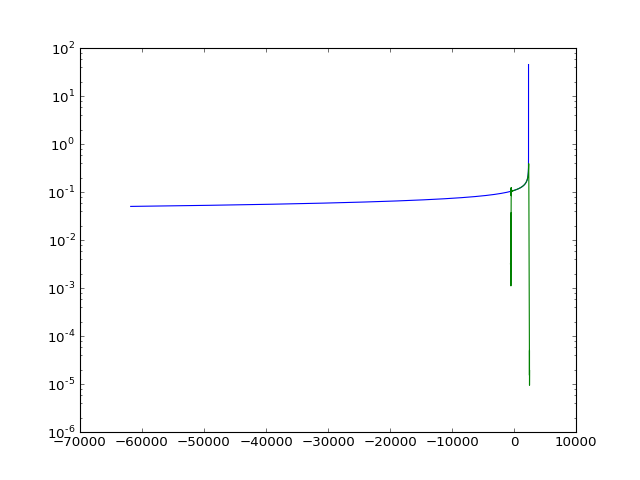

In [12]:
plt.close()
plt.semilogy(pn.T(), np.abs(pn.Data(0)))
plt.semilogy(nr.T(), np.abs(nr.Data(0)))

In [73]:
! /Users/boyle/.continuum/anaconda/envs/gwframes/bin/python ~/Research/Code/misc/GWFrames/Code/Scripts/HybridizeOneWaveform.py {data_dir} \
  --Waveform=rhOverM_Asymptotic_GeometricUnits_CoM.h5/Extrapolated_N4.dir --t1={metadata.relaxed_measurement_time} --t2=2000.0 \
  --InitialOmega_orb={Omega_orb_0} --Approximant=TaylorT4

/Users/boyle/.continuum/anaconda/envs/gwframes/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')
Reading and transforming NR data
Reading and analyzing Horizons.h5 data
Constructing PN data:
GWFrames.PNWaveform(Approximant=TaylorT4, delta=0.119691724704,
    chia_0=[ -4.24964667e-09  -3.03541238e-08   3.19971939e-01], chib_0=[  2.52539105e-08  -3.41851370e-08  -5.79849124e-01],
    Omega_orb_0=0.0197375356884, InitialOmega_orb=0.00606708934586,
    R_frame_i=[0.296025629172694, -2.51512442762923e-08, -3.03234599732828e-08, 0.95517999710678],
    MinStepsPerOrbit=32, PNWaveformModeOrder=3.5, PNOrbitalEvolutionOrder=4.0)
PostNewtonian/C++/PNEvolution_Q.cpp:311:EvolvePN_Q: Velocity v has become greater than 1.0.  This is a nice way for PN to stop.
Aligning PN and NR waveforms
Waveforms.cpp:2655:A

In [ ]:
--DirectAlignmentEvaluations 100

In [100]:
h = hybrid.EvaluateAtPoint(0.0, 0.0)[:-1]

In [46]:
hybrid = scri.SpEC.read_from_h5(data_dir + 'rhOverM_Inertial_Hybrid.h5')
hybrid = hybrid[:-1]

In [55]:
h = hybrid.SI_units(current_unit_mass_in_solar_masses=36.+29., distance_from_source_in_megaparsecs=410)

t_merger = 16.429
h.max_norm_time()
h.t = h.t - h.max_norm_time() + t_merger

<IPython.core.display.Javascript object>


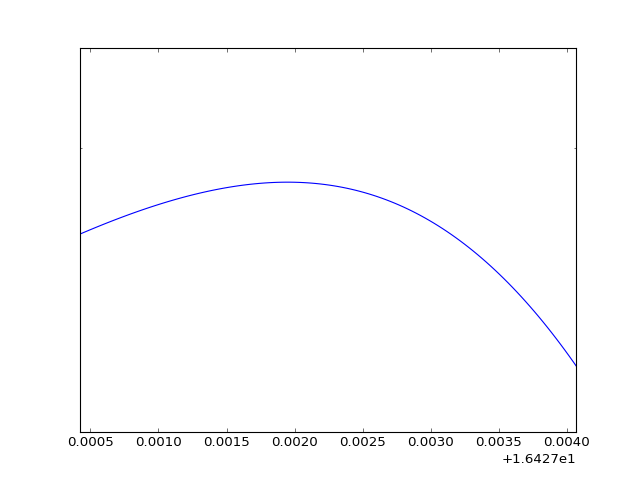

In [57]:
plt.close()
plt.semilogy(h.t, np.abs(h.data[:, 0]))

In [67]:
sampling_rate = 4096.  # Hz
dt = 1 / sampling_rate  # sec
t = np.linspace(0, 32, num=int(32*sampling_rate))
h_discrete = h.interpolate(t)
h_discrete.data[np.argmax(t>16.4739):, :] = 1e-40j

In [84]:
from utilities import transition_function

In [90]:
h_trimmed = h_discrete.copy()
h_trimmed.data = (1-transition_function(h_discrete.t, 16.445, 16.4737))[:, np.newaxis] * h_discrete.data

<IPython.core.display.Javascript object>


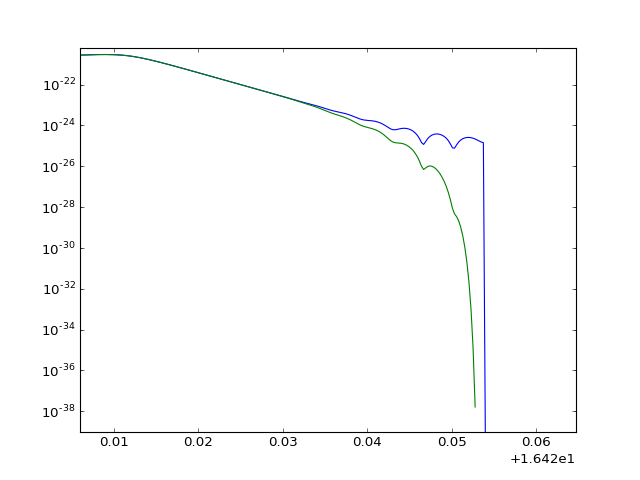

In [91]:
plt.close()
plt.semilogy(h_discrete.t, np.abs(h_discrete.data[:, 0]))
plt.semilogy(h_trimmed.t, np.abs(h_trimmed.data[:, 0]))

In [93]:
import quaternion
import spherical_functions as sf

In [100]:
sYlm = sf.SWSH(quaternion.one, h_discrete.spin_weight, h_discrete.LM)

(sYlm * h_trimmed.data).shape

(131072, 77)

In [107]:
h_data = np.tensordot(sYlm, h_trimmed.data, axes=([0, 1]))

In [121]:
np.savetxt('../Data/NR_GW150914.txt', np.vstack((h_data.real, h_data.imag)).T)

In [122]:
! head -n 1 ../Data/NR_GW150914.txt

-1.759765731369246126e-22 1.818289868851032387e-22
